In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from timeit import default_timer as timer

# Bellman operator

In [126]:
class Model:
    
    def __init__(self, α=0.4, β=0.96, δ=0.04, k_range=[5,20], N=1000):
        self.α, self.β, self.δ = α, β, δ
        self.k_range = k_range
        self.N = N
        self.grid = np.linspace(k_range[0], k_range[1], N)
        self.η = 1-(δ*α/(1/β+δ-1))
        self.k_ss = (α/(1/β+δ-1))**(1/(1-α))
        self.c_ss = (self.k_ss)**α-δ*self.k_ss
        
    def budget_constraint(self, k, k_prime):
        α, β, δ = self.α, self.β, self.δ
        return k**α+(1-δ)*k-k_prime
    
    def utility_function(self, k, k_prime):
        α, β, δ = self.α, self.β, self.δ
        c=self.budget_constraint(k, k_prime)
        return np.log(c)
    
    def consumption_hat(self, k):
        η, α = self.η, self.α
        return η*k**α
        

def bellman_operator(mod, w, Tw=None, compute_policy=False, compute_consumption=False):
    α, β, δ = mod.α, mod.β, mod.δ
    U = mod.utility_function
    BC = mod.budget_constraint
    
    if Tw is None:
        Tw = np.empty_like(w)
        
    if compute_policy:
        k_optims = np.empty_like(w)
    if compute_consumption:
        c_optims = np.empty_like(w)
        
    for i, k in enumerate(grid):
        def objective(k_prime):
            # interpolation - looking for optimal k_prime on the current 
            return -U(k, k_prime)-β*np.interp(x=k_prime, xp=grid, fp=w)
        
        k_star = fminbound(objective, mod.k_range[0]-1e-5, k+1e-5)
        c_star = BC(k, k_star)
        
        if compute_policy:
            k_optims[i]=k_star
        if compute_consumption:
            c_optims[i]=c_star
            
        Tw[i]=-objective(k_star)
  
    if compute_policy and compute_consumption:
        return Tw, k_optims, c_optims
    elif compute_policy:
        return Tw, k_optims
    elif compute_consumption:
        return Tw, c_optims
    else:
        return Tw

### Problem 1c)

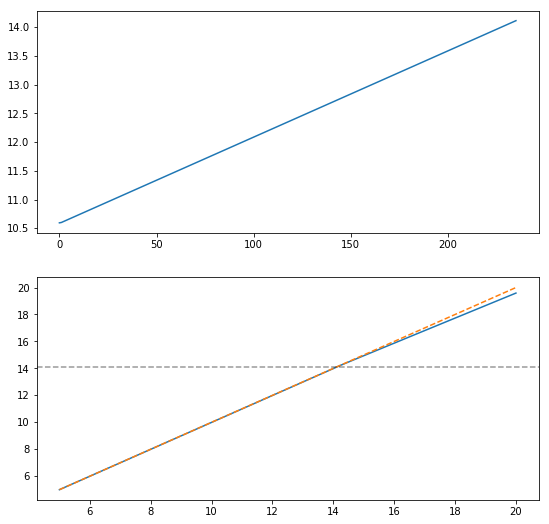

In [128]:
mod=Model()
grid=mod.grid
k_ss = mod.k_ss

k0 = k_ss*0.75
abs_diff_rng = np.abs(grid-k0)
k0_on_grid_index = np.where(abs_diff_rng==np.min(abs_diff_rng))[0][0]

abs_diff_rng = np.abs(grid-k_ss)
k_ss_on_grid_index = np.where(abs_diff_rng==np.min(abs_diff_rng))[0][0]

capital_path = np.empty(k_ss_on_grid_index+1-k0_on_grid_index)
capital_path[0]=k0

for i in range(k0_on_grid_index, k_ss_on_grid_index):
    capital_path[i-k0_on_grid_index+1] = k_policy_b[i]




fig, (ax2, ax) = plt.subplots(2,1,figsize=(9,9))

ax2.plot(range(len(capital_path)), capital_path)

ax.plot(grid, k_policy_b)
ax.plot(grid, grid, ls='dashed')
ax.axhline(mod.k_ss, c='k', alpha=0.4, ls='dashed')
plt.show()

### Problem 1b)

#### Steady states of variables

##### $ k^* = \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{1}{1-\alpha}} $

##### $ c^* = \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{\alpha}{1-\alpha}} - \delta \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{1}{1-\alpha}} $ 

#### Discounted lifetime utility

##### $\hat{v}_0(k) = \max \sum_{t=0}^{\infty} \log \eta k^\alpha$

[10.64301708 17.57448888 21.62913997]


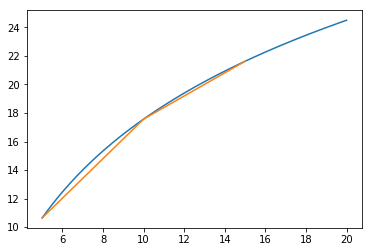

In [11]:
mod = Model()
β=mod.β
grid=mod.grid
w=np.log(mod.consumption_hat(mod.grid))/(1-β)

num=[5,10,15]
w_int = np.interp(num, grid, w)
print(w_int)

fig, ax = plt.subplots()
ax.plot(mod.grid, w)
ax.plot(num, w_int)
plt.show()

steady state of capital: 14.126197356650485

steady state of consumption: 2.3190507327167915

loop stopped at iteration:  172

final error:  9.953161189280024e-05

elapsed time: 121.17769216499983


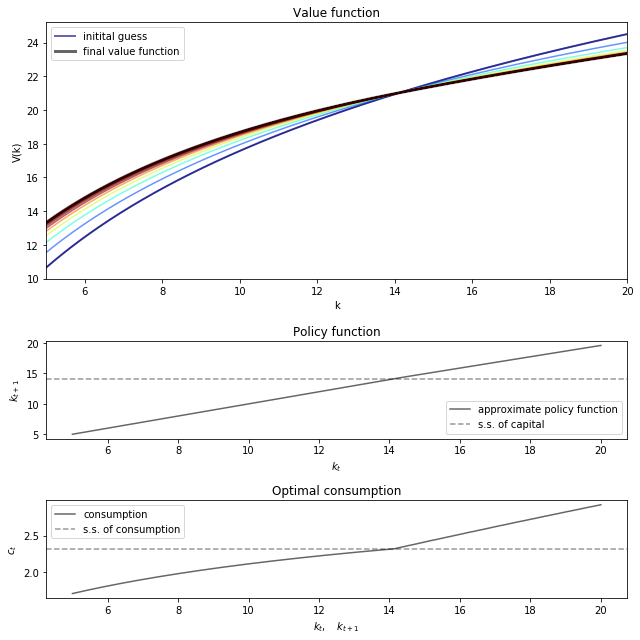

In [127]:
mod = Model()
grid=mod.grid
β=mod.β

print('steady state of capital: {0}\n'.format(mod.k_ss))
print('steady state of consumption: {0}\n'.format(mod.c_ss))

w=np.log(mod.consumption_hat(mod.grid))/(1-β)

max_iter = 250
           
fig = plt.figure(figsize=(9,9))
size = (4,1)
ax=plt.subplot2grid(size, (0,0), rowspan=2)
ax2=plt.subplot2grid(size, (2,0))
ax3=plt.subplot2grid(size, (3,0))
ax.set_xlim(np.min(grid), np.max(grid))

ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label='initital guess')

# PLOT VALUE FUNCTION
tol=0.0001
j=0
error=1
start = timer()
while j<max_iter and error>tol:
    w_new = bellman_operator(mod, w)
    
    if j%10==0:
        ax.plot(grid, w, color=plt.cm.jet(j/50), alpha=0.6)
            
    error = np.max(np.abs(w_new-w))
    w[:] = w_new
    j+=1
    
print('loop stopped at iteration: ', j)
print('\nfinal error: ', error)

w_final_b, k_policy_b, c_optimal_b = bellman_operator(mod, w, compute_policy=True, compute_consumption=True)

# PLOT VALUE FUNCTION
ax.plot(grid, w_final_b, color='k', lw=3, alpha=0.6, label='final value function')
ax.set(xlabel='k', ylabel='V(k)', title='Value function')
ax.legend()

# PLOT POLICY FUNCTIONS
ax2.plot(grid, k_policy_b, 'k-', alpha=0.6, label='approximate policy function')
ax2.axhline(mod.k_ss, alpha=0.4, ls='dashed', c='k', label='s.s. of capital')
ax2.set(xlabel='$k_t$', ylabel='$k_{t+1}$', title='Policy function')
ax2.legend()

ax3.plot(grid, c_optimal_b, 'k-', alpha=0.6, label='consumption')
ax3.axhline(mod.c_ss, alpha=0.4, ls='dashed',c='k', label='s.s. of consumption')
ax3.set(xlabel='$k_t, \quad k_{t+1}$', ylabel='$c_t$', title='Optimal consumption')
ax3.legend()

end = timer()
print('\nelapsed time: {}'.format(end-start))
plt.tight_layout()
plt.show()

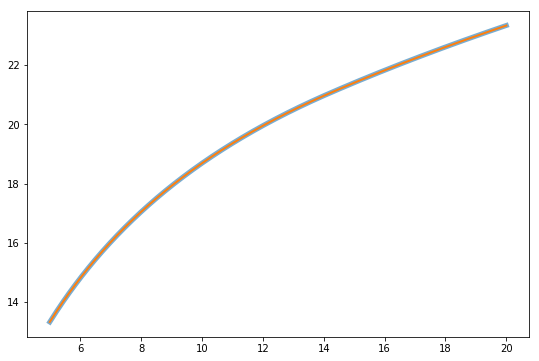

In [42]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(grid, w_final_b, lw=5, alpha=0.6)
ax.plot(grid, w_final_a, lw=2)
plt.show()

### Problem 1a)

loop stopped at iteration:  218

elapsed time: 145.5380098400001


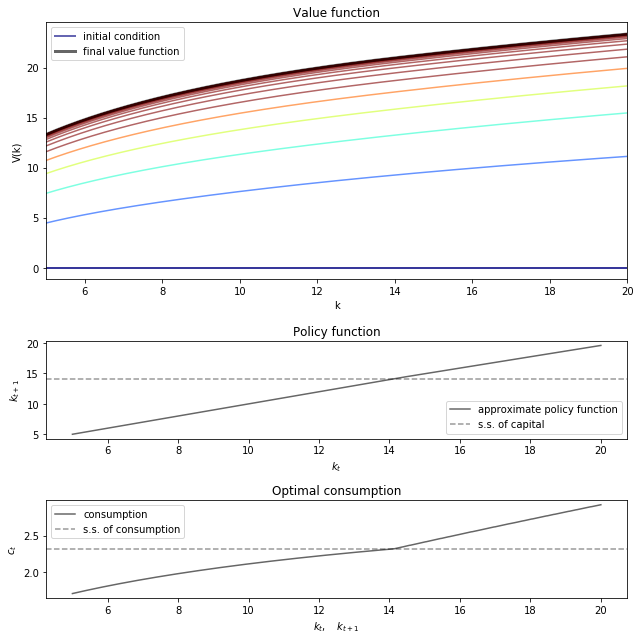

In [78]:
mod = Model()
grid=mod.grid
β=mod.β

max_iter = 250
w = np.zeros(mod.N) # initital guess

fig = plt.figure(figsize=(9,9))
size = (4,1)
ax=plt.subplot2grid(size, (0,0), rowspan=2)
ax2=plt.subplot2grid(size, (2,0))
ax3=plt.subplot2grid(size, (3,0))
ax.set_xlim(np.min(grid), np.max(grid))

# VALUE FUNCTION
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)

tol=0.0001
j=0
error=1
start = timer()
while j<max_iter and error>tol:
    w_new = bellman_operator(mod, w)
    error = np.max(np.abs(w_new-w))
    if j%10==0:
        ax.plot(grid, w, color=plt.cm.jet(j/50), alpha=0.6)
            
    error = np.max(np.abs(w_new-w))
    w[:] = w_new
    j+=1
    
print('loop stopped at iteration: ', j)

w_final_a, k_policy_a, c_optimal_a = bellman_operator(mod, w, compute_policy=True, compute_consumption=True)

ax.plot(grid, w_final_a, color='k', lw=3, alpha=0.6, label='final value function')
ax.set(xlabel='k', ylabel='V(k)', title='Value function')
ax.legend()

# PLOT POLICY FUNCTIONS
ax2.plot(grid, k_policy_a, 'k-', alpha=0.6, label='approximate policy function')
ax2.axhline(mod.k_ss, alpha=0.4, ls='dashed', c='k', label='s.s. of capital')
ax2.set(xlabel='$k_t$', ylabel='$k_{t+1}$', title='Policy function')
ax2.legend()

ax3.plot(grid, c_optimal_a, 'k-', alpha=0.6, label='consumption')
ax3.axhline(mod.c_ss, alpha=0.4, ls='dashed',c='k', label='s.s. of consumption')
ax3.set(xlabel='$k_t, \quad k_{t+1}$', ylabel='$c_t$', title='Optimal consumption')
ax3.legend()

end = timer()
print('\nelapsed time: {}'.format(end-start))
plt.tight_layout()
plt.show()